<a href="https://colab.research.google.com/github/Jordankham/IS115_Final/blob/main/KhamvongsoukJordan_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Team Members: Jordan Khamvongsouk and Jack Seal
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
sales = pd.read_csv('/content/drive/My Drive/Data/SalesData.csv')

In [ ]:
sales.head()
##The data includes three months worth of data for around 500 sales reps. The reps were measured on the following variables.
##Attainment : Your output variable. The percent of quota that each sales rep sold
##Calls : The number of prospecting calls each sales rep made
##Meetings : The number of meetings each rep had with potential clients
##HasDegree : Whether the rep has a college degree. Includes percentages for partially completed degrees
##HoursWorked : The number of hours worked by the rep in the quarter
##Emails : The number of emails sent by the rep
##Prizes : The amount of prize money the rep won in various competitions
##Questions : How many questions asked by potential clients during meetings
##TeamSize : How big the rep's team was
##Ratio : The ratio of time spent talking by the rep vs. the client during meetings
##TrainSales : The amount of time spent on sales trainings
##Live : Percentage of meetings that were live compared to over the phone
##Sentiment : The quantied sentiment of the language used during meetings
##TrainProd : The amount of time spent on product trainings
##Engagement : How engaged the sales rep was as measured by a survey early in the quarter
##Pipeline : The dollar amount of all deals generated by the rep

,Attainment,Calls,Emails,Engagement,HasDegree,HoursWorked,Live,Meetings,Pipeline,Prizes,Questions,Ratio,Sentiment,TeamSize,TrainProd,TrainSales
0,0.053575,61.0,929,3.424084,0.75,454.563783,0.243379,21,256354,960,6.0,0.620010,5.050705,10,21.0,65
1,0.060142,70.0,517,3.128567,1.00,464.381755,0.207529,21,252552,1406,3.0,0.882232,4.934229,8,19.0,62
2,0.062694,69.0,231,3.237094,0.50,470.261626,0.136013,21,282094,1655,4.0,0.812933,6.146106,6,27.0,64
3,0.072924,33.0,532,NaN,0.25,435.785692,0.220848,18,222374,2385,400.0,0.732378,5.186325,13,17.0,64
4,0.077626,38.0,428,3.612517,0.75,481.584611,0.353637,29,217384,1733,4.0,0.833299,5.470473,8,18.0,55


In [ ]:
# STEP 1 DATA CLEANING
# Functions to find outliers
def get_outlier_minmax(col):
  if pd.api.types.is_numeric_dtype(col):
    if col.skew() > 1 or col.skew() < -1:
      q1 = col.quantile(.25)
      q3 = col.quantile(.75)
      min = q1 - (1.5 * (q3 - q1))
      max = q3 + (1.5 * (q3 - q1))
      theory = 'Tukey 1.5IQR'
    else:
      min = col.mean() - (col.std() * 3)
      max = col.mean() + (col.std() * 3)
      theory = '3σ from μ'
    min_count = (col < min).sum()
    max_count = (col > max).sum()
  else:
    min = col.min()
    max = col.max()
    min_count = (col == col.min()).sum()
    max_count = (col == col.max()).sum()
    theory = "Categorical"
  
  return min, min_count, max, max_count, theory

def detect_outliers(df, method='auto'):
  import pandas as pd

  summary_table = pd.DataFrame(columns=['total values', 'outlier min', 'count below', 'outlier max', 'count above', 'method'])

  # Loop through each column in the dataframe that is numeric, not binary, and not empty
  for col in df:
    if pd.api.types.is_numeric_dtype(df[col]) and (len(df[col].value_counts()) > 0) and not all(df[col].value_counts().index.isin([0, 1])):
      # Get the min, max and theory
      min, min_count, max, max_count, theory = get_outlier_minmax(df[col])
      # Place them in a summary df as well as a count of the outliers above and below the range; also report the theory used
      summary_table.loc[col] = (df[col].count(), min, min_count, max, max_count, theory)
  return summary_table

In [ ]:
# Outliers for the dataset
detect_outliers(sales)

,total values,outlier min,count below,outlier max,count above,method
Attainment,478,-0.609576,0,1.795685,17,Tukey 1.5IQR
Calls,473,24.715405,1,95.715885,0,3σ from μ
Emails,478,-478.625000,0,1584.375000,17,Tukey 1.5IQR
Engagement,473,2.367018,0,5.046764,0,3σ from μ
HasDegree,478,-0.500000,0,1.500000,4,Tukey 1.5IQR
HoursWorked,473,428.038939,3,532.805680,6,Tukey 1.5IQR
Live,478,-0.084663,0,0.969638,0,3σ from μ
Meetings,478,6.305889,0,41.715032,0,3σ from μ
Pipeline,478,151697.776362,0,421955.089747,0,3σ from μ
Prizes,478,502.132505,0,4013.574608,0,3σ from μ


In [ ]:
# dropping outliers
def clean_outliers(df, results='append'): # By default, append new columns of outlier replacement rather than remove outliers
  import numpy as np

  # Create a column to store 0 = not outliers in record, or 1 = one or more outliers in the record
  df['outlier'] = [np.nan for _ in range(len(df))]

  # Loop through each column in the dataframe that is numeric, not binary, and not empty
  for col in df:
    if pd.api.types.is_numeric_dtype(df[col]) and (len(df[col].value_counts()) > 0) and not all(df[col].value_counts().index.isin([0, 1])):
      
      # Get the values we need from the get_outlier_minmax function()
      min, min_count, max, max_count, theory = get_outlier_minmax(df[col])
      if min_count > 0 or max_count > 0:            # If there are any outliers:
        # Create a couple of empty columns; specify the length of the columns based on the length of the dataframe passed in
        df[col + '_no_outliers'] = [np.nan for _ in range(len(df))]
        
      # Determine how to clean
      if results=='append':
        for i, value in enumerate(df[col]):
          if value < min:
            df.loc[i, col + '_no_outliers'] = min   # Add the new min value to the list
            df.loc[i, 'outlier'] = 1                # Mark it as an outlier
          elif value > max:
            df.loc[i, col + '_no_outliers'] = max   # Add the new max value to the list
            df.loc[i, 'outlier'] = 1                # Mark it as an outlier
          else:
            df.loc[i, col + '_no_outliers'] = value # Keep the original value
            if not df.loc[i, 'outlier'] == 1:     # Mark it as an outlier
              df.loc[i, 'outlier'] = 0              # Only set it to 0 if it wasn't previously set to 1
      else: # (if not 'append'):
        # Filter out the outliers by setting the df to itself only for records greater than the min or greater less the max
        df = df[df[col] > min]  
        df = df[df[col] < max]

  return df
clean_outliers(sales)

,Attainment,Calls,Emails,Engagement,HasDegree,HoursWorked,Live,Meetings,Pipeline,Prizes,Questions,Ratio,Sentiment,TeamSize,TrainProd,TrainSales,outlier,Attainment_no_outliers,Calls_no_outliers,Emails_no_outliers,Engagement_no_outliers,HasDegree_no_outliers,HoursWorked_no_outliers,Live_no_outliers,Meetings_no_outliers,Pipeline_no_outliers,Prizes_no_outliers,Questions_no_outliers,Ratio_no_outliers,Sentiment_no_outliers,TeamSize_no_outliers,TrainProd_no_outliers,TrainSales_no_outliers
0,0.053575,61.0,929,3.424084,0.75,454.563783,0.243379,21,256354,960,6.0,0.620010,5.050705,10,21.0,65,0.0,0.053575,61.0,929.0,3.424084,0.75,454.563783,0.243379,21.0,256354.0,960.0,6.0,0.620010,5.050705,10.0,21.0,65.0
1,0.060142,70.0,517,3.128567,1.00,464.381755,0.207529,21,252552,1406,3.0,0.882232,4.934229,8,19.0,62,0.0,0.060142,70.0,517.0,3.128567,1.00,464.381755,0.207529,21.0,252552.0,1406.0,3.0,0.882232,4.934229,8.0,19.0,62.0
2,0.062694,69.0,231,3.237094,0.50,470.261626,0.136013,21,282094,1655,4.0,0.812933,6.146106,6,27.0,64,0.0,0.062694,69.0,231.0,3.237094,0.50,470.261626,0.136013,21.0,282094.0,1655.0,4.0,0.812933,6.146106,6.0,27.0,64.0
3,0.072924,33.0,532,NaN,0.25,435.785692,0.220848,18,222374,2385,400.0,0.732378,5.186325,13,17.0,64,1.0,0.072924,33.0,532.0,NaN,0.25,435.785692,0.220848,18.0,222374.0,2385.0,6.5,0.732378,5.186325,13.0,17.0,64.0
4,0.077626,38.0,428,3.612517,0.75,481.584611,0.353637,29,217384,1733,4.0,0.833299,5.470473,8,18.0,55,0.0,0.077626,38.0,428.0,3.612517,0.75,481.584611,0.353637,29.0,217384.0,1733.0,4.0,0.833299,5.470473,8.0,18.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,2.310336,71.0,635,3.903871,0.25,487.205679,0.620823,23,321498,2687,5.0,0.694004,6.706751,8,27.0,69,1.0,1.795685,71.0,635.0,3.903871,0.25,487.205679,0.620823,23.0,321498.0,2687.0,5.0,0.694004,6.706751,8.0,27.0,69.0
474,2.338629,69.0,303,3.616292,0.00,457.488144,0.592753,26,324659,3150,5.0,0.685805,7.058483,9,32.0,54,1.0,1.795685,69.0,303.0,3.616292,0.00,457.488144,0.592753,26.0,324659.0,3150.0,5.0,0.685805,7.058483,9.0,32.0,54.0
475,2.548678,57.0,818,4.185094,0.25,470.960123,0.594773,24,347032,2721,4.0,0.634341,7.162894,11,29.0,75,1.0,1.795685,57.0,818.0,4.185094,0.25,470.960123,0.594773,24.0,347032.0,2721.0,4.0,0.634341,7.162894,11.0,29.0,75.0
476,2.669492,61.0,655,3.999089,0.25,479.703249,0.619596,31,269709,3227,6.0,0.615081,7.447181,8,31.0,75,1.0,1.795685,61.0,655.0,3.999089,0.25,479.703249,0.619596,31.0,269709.0,3227.0,6.0,0.615081,7.447181,8.0,31.0,75.0


In [ ]:
# Finding missing values
def missing_summary(df):
  total_obs = df.shape[0] * df.shape[1]
  total_missing = df.isnull().sum().sum()

  print('Total Missing')
  print(str(total_missing))

  print('\nMissing Data by Column')
  print(df.isnull().sum() / df.shape[0])

In [ ]:
#Number of/Percentage of missing data by column
missing_summary(sales)

Total Missing
60

Missing Data by Column
Attainment                 0.00000
Calls                      0.01046
Emails                     0.00000
Engagement                 0.01046
HasDegree                  0.00000
HoursWorked                0.01046
Live                       0.00000
Meetings                   0.00000
Pipeline                   0.00000
Prizes                     0.00000
Questions                  0.01046
Ratio                      0.00000
Sentiment                  0.01046
TeamSize                   0.00000
TrainProd                  0.01046
TrainSales                 0.00000
outlier                    0.00000
Attainment_no_outliers     0.00000
Calls_no_outliers          0.01046
Emails_no_outliers         0.00000
Engagement_no_outliers     0.01046
HasDegree_no_outliers      0.00000
HoursWorked_no_outliers    0.01046
Live_no_outliers           0.00000
Meetings_no_outliers       0.00000
Pipeline_no_outliers       0.00000
Prizes_no_outliers         0.00000
Questions_no_o

In [ ]:
# Filling missing values with column median imputations
sales = sales.fillna(
    value = {
        'Calls': sales['Calls'].median(),
        'Engagement': sales['Engagement'].median(),
        'HoursWorked': sales['HoursWorked'].median(),
        'Questions': sales['Questions'].median(),
        'Sentiment': sales['Sentiment'].median(),
        'TrainProd': sales['TrainProd'].median()
    }
)

In [ ]:
#STEP 2 EDA
def summary(df):
  output = pd.DataFrame(columns=['Min', 'Max', 'Median', 'Mean', 'StDeviation', 'isNormal'])

  for col in df:
    if abs(df[col].kurt()) <= 1 and df[col].skew() <=1:
      normal = 'Yes'
    else:
      normal = 'No'
    output.loc[col] = [df[col].min(), df[col].max(), df[col].median(), df[col].mean(), df[col].std(), normal]
  return output

In [ ]:
summary(sales)

,Min,Max,Median,Mean,StDeviation,isNormal
Attainment,0.053575,3.296522,0.555141,0.676154,0.502989,No
Calls,18.000000,93.000000,61.000000,60.223849,11.771501,Yes
Emails,13.000000,2694.000000,518.000000,614.131799,431.011357,No
Engagement,2.648679,4.629195,3.705335,3.706875,0.444277,No
HasDegree,0.000000,75.000000,0.500000,0.791318,3.931441,No
HoursWorked,413.711466,52443.833060,481.541723,975.788827,4831.671946,No
Live,-0.063946,0.845823,0.416401,0.442488,0.175717,Yes
Meetings,7.000000,41.000000,24.000000,24.010460,5.901524,Yes
Pipeline,182589.000000,393524.000000,287328.000000,286826.433054,45042.885564,No
Prizes,625.000000,3787.000000,2260.500000,2257.853556,585.240350,Yes


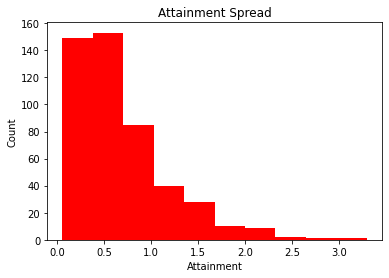

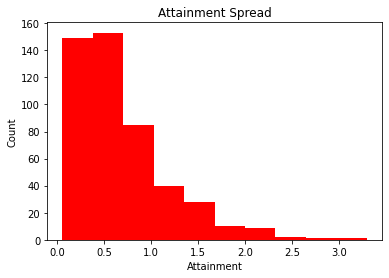

In [ ]:
# Histogram of output variable
plt.hist(sales.Attainment, color= 'r')
plt.title('Attainment Spread')
plt.ylabel('Count')
plt.xlabel('Attainment')
plt.show()

In [ ]:
# STEP 3 PICKING VARIABLE
sales.corr()
# Variables with highest correlation: Engagement, Live, Prizes. 
# Pipeline has high correlation with Attainment but we think that high Pipeline is a result of a high attainment value and doesn't increase
#

,Attainment,Calls,Emails,Engagement,HasDegree,HoursWorked,Live,Meetings,Pipeline,Prizes,Questions,Ratio,Sentiment,TeamSize,TrainProd,TrainSales,outlier,Attainment_no_outliers,Calls_no_outliers,Emails_no_outliers,Engagement_no_outliers,HasDegree_no_outliers,HoursWorked_no_outliers,Live_no_outliers,Meetings_no_outliers,Pipeline_no_outliers,Prizes_no_outliers,Questions_no_outliers,Ratio_no_outliers,Sentiment_no_outliers,TeamSize_no_outliers,TrainProd_no_outliers,TrainSales_no_outliers
Attainment,1.000000,0.068944,0.031881,0.619398,-0.031320,0.039580,0.619961,0.028506,0.632408,0.365090,0.011168,-0.320747,-0.066083,-0.292214,0.019034,-0.036976,0.248919,0.981393,0.069264,0.023302,0.622207,-0.136265,0.066927,0.619961,0.028506,0.632408,0.365090,0.352043,-0.320747,0.549061,-0.292214,0.595505,0.325043
Calls,0.068944,1.000000,0.030169,0.067171,0.015757,0.021072,0.056230,0.006273,0.033943,-0.002701,-0.071430,-0.095313,0.036476,-0.054697,0.037439,0.007160,-0.030363,0.071607,0.999666,0.028959,0.067650,-0.043014,-0.003830,0.056230,0.006273,0.033943,-0.002701,0.072044,-0.095313,0.030371,-0.054697,0.026262,0.028204
Emails,0.031881,0.030169,1.000000,-0.008674,0.003764,0.005365,0.001022,0.034895,0.038330,0.008721,-0.057217,0.036554,-0.044990,-0.026034,-0.046127,0.015826,0.158343,0.028216,0.030234,0.981630,-0.008708,0.040540,0.001955,0.001022,0.034895,0.038330,0.008721,-0.048188,0.036554,-0.039731,-0.026034,-0.002420,0.019018
Engagement,0.619398,0.067171,-0.008674,1.000000,-0.031139,0.008870,0.723899,0.029871,0.745815,0.387125,0.009042,-0.425152,-0.067009,-0.390411,0.085439,-0.021090,0.105830,0.662474,0.067382,-0.011698,1.000000,-0.093762,0.047700,0.723899,0.029871,0.745815,0.387125,0.416049,-0.425152,0.666811,-0.390411,0.695219,0.358085
HasDegree,-0.031320,0.015757,0.003764,-0.031139,1.000000,-0.010056,0.005909,-0.009800,-0.019453,-0.073055,-0.004719,0.007461,-0.009116,0.014722,-0.005556,-0.014565,0.151379,-0.030616,0.015989,0.006611,-0.031142,0.302979,-0.043230,0.005909,-0.009800,-0.019453,-0.073055,0.011036,0.007461,-0.098867,0.014722,-0.033580,0.069352
HoursWorked,0.039580,0.021072,0.005365,0.008870,-0.010056,1.000000,0.043195,-0.000222,0.055069,0.078058,-0.012096,-0.001535,-0.011046,-0.062576,-0.010090,-0.009785,0.200541,0.047589,0.021108,0.009568,0.008867,-0.021242,0.273861,0.043195,-0.000222,0.055069,0.078058,-0.058638,-0.001535,-0.024264,-0.062576,0.024554,0.054157
Live,0.619961,0.056230,0.001022,0.723899,0.005909,0.043195,1.000000,0.032504,0.721688,0.425667,0.048579,-0.356669,-0.070078,-0.346946,0.065311,-0.028659,0.141498,0.656593,0.056309,-0.002570,0.727556,-0.111871,0.039437,1.000000,0.032504,0.721688,0.425667,0.410091,-0.356669,0.658103,-0.346946,0.675300,0.308723
Meetings,0.028506,0.006273,0.034895,0.029871,-0.009800,-0.000222,0.032504,1.000000,0.002264,0.031944,-0.050418,0.009463,-0.037507,0.030377,0.045201,0.031150,0.046381,0.020431,0.006722,0.032290,0.029923,-0.006631,-0.029913,0.032504,1.000000,0.002264,0.031944,0.026682,0.009463,-0.014296,0.030377,0.058168,0.048649
Pipeline,0.632408,0.033943,0.038330,0.745815,-0.019453,0.055069,0.721688,0.002264,1.000000,0.398821,0.023087,-0.414200,-0.071568,-0.352331,0.076168,-0.026797,0.120776,0.670505,0.033583,0.036690,0.748591,-0.112600,0.044077,0.721688,0.002264,1.000000,0.398821,0.364608,-0.414200,0.643740,-0.352331,0.677371,0.387856
Prizes,0.365090,-0.002701,0.008721,0.387125,-0.073055,0.078058,0.425667,0.031944,0.398821,1.000000,-0.038335,-0.197465,0.000624,-0.159685,-0.029030,-0.085140,0.035768,0.384947,-0.002545,0.001258,0.391703,-0.073082,0.080033,0.425667,0.031944,0.398821,1.000000,0.172597,-0.197465,0.371797,-0.159685,0.361856,0.114595


,Attainment,Calls,Emails,Engagement,HasDegree,HoursWorked,Live,Meetings,Pipeline,Prizes,Questions,Ratio,Sentiment,TeamSize,TrainProd,TrainSales,outlier,Attainment_no_outliers,Calls_no_outliers,Emails_no_outliers,Engagement_no_outliers,HasDegree_no_outliers,HoursWorked_no_outliers,Live_no_outliers,Meetings_no_outliers,Pipeline_no_outliers,Prizes_no_outliers,Questions_no_outliers,Ratio_no_outliers,Sentiment_no_outliers,TeamSize_no_outliers,TrainProd_no_outliers,TrainSales_no_outliers
Attainment,1.000000,0.068944,0.031881,0.619398,-0.031320,0.039580,0.619961,0.028506,0.632408,0.365090,0.011168,-0.320747,-0.066083,-0.292214,0.019034,-0.036976,0.248919,0.981393,0.069264,0.023302,0.622207,-0.136265,0.066927,0.619961,0.028506,0.632408,0.365090,0.352043,-0.320747,0.549061,-0.292214,0.595505,0.325043
Calls,0.068944,1.000000,0.030169,0.067171,0.015757,0.021072,0.056230,0.006273,0.033943,-0.002701,-0.071430,-0.095313,0.036476,-0.054697,0.037439,0.007160,-0.030363,0.071607,0.999666,0.028959,0.067650,-0.043014,-0.003830,0.056230,0.006273,0.033943,-0.002701,0.072044,-0.095313,0.030371,-0.054697,0.026262,0.028204
Emails,0.031881,0.030169,1.000000,-0.008674,0.003764,0.005365,0.001022,0.034895,0.038330,0.008721,-0.057217,0.036554,-0.044990,-0.026034,-0.046127,0.015826,0.158343,0.028216,0.030234,0.981630,-0.008708,0.040540,0.001955,0.001022,0.034895,0.038330,0.008721,-0.048188,0.036554,-0.039731,-0.026034,-0.002420,0.019018
Engagement,0.619398,0.067171,-0.008674,1.000000,-0.031139,0.008870,0.723899,0.029871,0.745815,0.387125,0.009042,-0.425152,-0.067009,-0.390411,0.085439,-0.021090,0.105830,0.662474,0.067382,-0.011698,1.000000,-0.093762,0.047700,0.723899,0.029871,0.745815,0.387125,0.416049,-0.425152,0.666811,-0.390411,0.695219,0.358085
HasDegree,-0.031320,0.015757,0.003764,-0.031139,1.000000,-0.010056,0.005909,-0.009800,-0.019453,-0.073055,-0.004719,0.007461,-0.009116,0.014722,-0.005556,-0.014565,0.151379,-0.030616,0.015989,0.006611,-0.031142,0.302979,-0.043230,0.005909,-0.009800,-0.019453,-0.073055,0.011036,0.007461,-0.098867,0.014722,-0.033580,0.069352
HoursWorked,0.039580,0.021072,0.005365,0.008870,-0.010056,1.000000,0.043195,-0.000222,0.055069,0.078058,-0.012096,-0.001535,-0.011046,-0.062576,-0.010090,-0.009785,0.200541,0.047589,0.021108,0.009568,0.008867,-0.021242,0.273861,0.043195,-0.000222,0.055069,0.078058,-0.058638,-0.001535,-0.024264,-0.062576,0.024554,0.054157
Live,0.619961,0.056230,0.001022,0.723899,0.005909,0.043195,1.000000,0.032504,0.721688,0.425667,0.048579,-0.356669,-0.070078,-0.346946,0.065311,-0.028659,0.141498,0.656593,0.056309,-0.002570,0.727556,-0.111871,0.039437,1.000000,0.032504,0.721688,0.425667,0.410091,-0.356669,0.658103,-0.346946,0.675300,0.308723
Meetings,0.028506,0.006273,0.034895,0.029871,-0.009800,-0.000222,0.032504,1.000000,0.002264,0.031944,-0.050418,0.009463,-0.037507,0.030377,0.045201,0.031150,0.046381,0.020431,0.006722,0.032290,0.029923,-0.006631,-0.029913,0.032504,1.000000,0.002264,0.031944,0.026682,0.009463,-0.014296,0.030377,0.058168,0.048649
Pipeline,0.632408,0.033943,0.038330,0.745815,-0.019453,0.055069,0.721688,0.002264,1.000000,0.398821,0.023087,-0.414200,-0.071568,-0.352331,0.076168,-0.026797,0.120776,0.670505,0.033583,0.036690,0.748591,-0.112600,0.044077,0.721688,0.002264,1.000000,0.398821,0.364608,-0.414200,0.643740,-0.352331,0.677371,0.387856
Prizes,0.365090,-0.002701,0.008721,0.387125,-0.073055,0.078058,0.425667,0.031944,0.398821,1.000000,-0.038335,-0.197465,0.000624,-0.159685,-0.029030,-0.085140,0.035768,0.384947,-0.002545,0.001258,0.391703,-0.073082,0.080033,0.425667,0.031944,0.398821,1.000000,0.172597,-0.197465,0.371797,-0.159685,0.361856,0.114595


In [ ]:
# Bivariate analysis with the correlation column
def summary(df):
  output = pd.DataFrame(columns=['Min', 'Max', 'Median', 'Mean', 'StDeviation', 'isNormal', 'Correlation'])

  for col in df:
    if abs(df[col].kurt()) <= 1 and df[col].skew() <=1:
      normal = 'Yes'
    else:
      normal = 'No'
    output.loc[col] = [df[col].min(), df[col].max(), df[col].median(), df[col].mean(), df[col].std(), normal, df['Attainment'].corr(df[col])]
  return output

summary(sales)

,Min,Max,Median,Mean,StDeviation,isNormal,Correlation
Attainment,0.053575,3.296522,0.555141,0.676154,0.502989,No,1.000000
Calls,18.000000,93.000000,61.000000,60.223849,11.771501,Yes,0.068944
Emails,13.000000,2694.000000,518.000000,614.131799,431.011357,No,0.031881
Engagement,2.648679,4.629195,3.705335,3.706875,0.444277,No,0.619398
HasDegree,0.000000,75.000000,0.500000,0.791318,3.931441,No,-0.031320
HoursWorked,413.711466,52443.833060,481.541723,975.788827,4831.671946,No,0.039580
Live,-0.063946,0.845823,0.416401,0.442488,0.175717,Yes,0.619961
Meetings,7.000000,41.000000,24.000000,24.010460,5.901524,Yes,0.028506
Pipeline,182589.000000,393524.000000,287328.000000,286826.433054,45042.885564,No,0.632408
Prizes,625.000000,3787.000000,2260.500000,2257.853556,585.240350,Yes,0.365090


,Min,Max,Median,Mean,StDeviation,isNormal,Correlation
Attainment,0.053575,3.296522,0.555141,0.676154,0.502989,No,1.000000
Calls,18.000000,93.000000,61.000000,60.223849,11.771501,Yes,0.068944
Emails,13.000000,2694.000000,518.000000,614.131799,431.011357,No,0.031881
Engagement,2.648679,4.629195,3.705335,3.706875,0.444277,No,0.619398
HasDegree,0.000000,75.000000,0.500000,0.791318,3.931441,No,-0.031320
HoursWorked,413.711466,52443.833060,481.541723,975.788827,4831.671946,No,0.039580
Live,-0.063946,0.845823,0.416401,0.442488,0.175717,Yes,0.619961
Meetings,7.000000,41.000000,24.000000,24.010460,5.901524,Yes,0.028506
Pipeline,182589.000000,393524.000000,287328.000000,286826.433054,45042.885564,No,0.632408
Prizes,625.000000,3787.000000,2260.500000,2257.853556,585.240350,Yes,0.365090


In [ ]:
EDA_Summary = summary(sales)

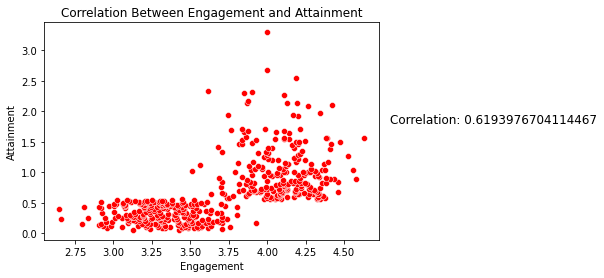

In [ ]:
# STEP 4 DEFENDING CHOICES
# Correlation is useful for finding trends and figuring out which variables are related with one another. High correlation means that as one variable
# increases, the other variable tends to increase as well. In this case, it is useful to see which variable could impact the salespersons' overall
# performance(attainment). Correlation does not mean causation though.


# Scatterplot of 3 strongest correlation variables to the output variable
# Scatterplot for Engagement and Attainment
sns.scatterplot(x='Engagement', y='Attainment', data=sales, color="r")
plt.title('Correlation Between Engagement and Attainment')
txtstr = 'Correlation: ' + str(sales['Attainment'].corr(sales['Engagement']))
plt.text(4.8, 1.8, txtstr, fontsize=12)
plt.show()

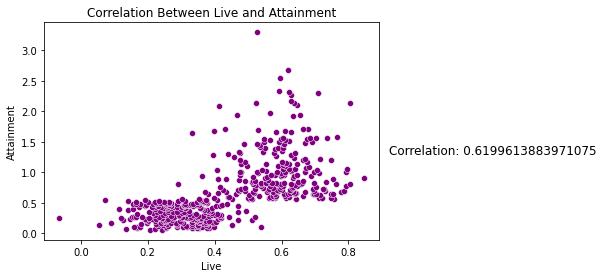

In [ ]:
# Scatterplot for Live and Attainment
sns.scatterplot(x='Live', y='Attainment', data=sales, color='purple')
plt.title('Correlation Between Live and Attainment')
txtstr = 'Correlation: ' + str(sales['Attainment'].corr(sales['Live']))
plt.text(.92, 1.3, txtstr, fontsize=12)
plt.show()

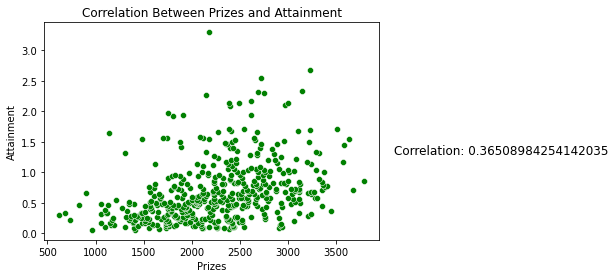

In [ ]:
# Scatterplot for Prizes and Attainment
sns.scatterplot(x='Prizes', y='Attainment', data=sales, color= 'g')
plt.title('Correlation Between Prizes and Attainment')
txtstr = 'Correlation: ' + str(sales['Attainment'].corr(sales['Prizes']))
plt.text(4100, 1.3, txtstr, fontsize=12)
plt.show()

In [ ]:
# CSV file of clean dataset
sales.to_csv('KhamvongsoukJordan_Data.csv')
EDA_Summary.to_csv('KhamvongsoukJordan_EDA.csv')